In [1]:
# -- use this line at the beginning of your notebook to turn on interactive plots
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget
#%matplotlib 
#%matplotlib ipympl

# Imports
import sys
import matplotlib.pyplot as plt  # plotting library
from matplotlib import colors
import numpy as np  # work with numeric arrays without labeled axes
import xarray as xr  # work with arrays with labeled axes
import xrscipy.signal as dsp  # xarray signal filtering etc.
import scipy as sps
from cdb_extras import xarray_support as cdbxr  # access to COMPASS Database (CDB)
import pickle # to save data
from pathlib import Path # to easily work with different files
from progressbar import ProgressBar
from typing import Optional, Union
from dataclasses import dataclass
from typing import Optional
#plt.rcParams.update({'font.size': 14})


from core.pedestal_fit import PedestalParams, get_thomson_data, fit, pedestal_params_extraction
from core.sawtooth_extraction import ST_detector, ST_time_and_phase, ST_detector_plot
from core.pedestal_ploting import load_pedestal_data, scatter_pedestal_params, get_ELM_ST_phase_and_duration, scatter_pedestal_params_4plots, get_elm_length_and_time

# Only use Thomson data from this normalized psi value and up
psi_n_lim = 0.6
savesaw="/compass/home/odlozilik/repos/ELM-Sawtooth/sawtooth_data"
saveped="/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals"

# <ins> Pedestal fit</ins>

#### Compute multiple fits of pedestals:

In [3]:
#test=pedestal_params_extraction(18254, psi_n_lim,save_path=saveped)

# Create a list here of all the shots you want to extract pedestal parameters for.
shot_list = [18252,18254,18255,18257,18260,18261,18263,18266,18267,18273,18274,18275,18276,18277]
             
for shot_nr in shot_list:
    print(f"\n#### EXTRACTING PEDESTAL PARAMETERS FROM SHOT {shot_nr}\n")
    pedestal_params_extraction(shot_nr, psi_n_lim,save_path=saveped)



#### EXTRACTING PEDESTAL PARAMETERS FROM SHOT 18252



  0% (0 of 55) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Using stray corrected data
Number of H-mode intervals : 1


 20% (11 of 55) |####                    | Elapsed Time: 0:00:00 ETA:   0:00:03
 21% (12 of 55) |#####                   | Elapsed Time: 0:00:01 ETA:   0:00:05


KeyboardInterrupt: 

#### Test fit algorithm with plot:

Using stray corrected data


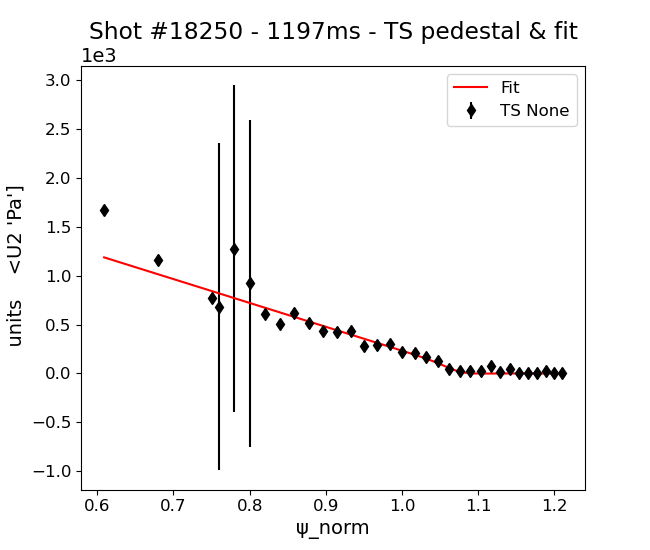

In [3]:
# Just for testing the fitting algorithm
if True: # Set to True and run this block of code to test the fitting algorithm
    shot_nr = 18250
    time = 1200
    ne, ne_err, Te, Te_err, pe, pe_err, psi_n, psi_n_fit_coords, t_H_mode_start, t_H_mode_end = get_thomson_data(shot_nr, psi_n_lim)
    d = pe.sel(time=time, method='nearest')
    e = pe_err.sel(time=time, method='nearest')
    psi_n_one = psi_n.sel(time=time, method='nearest')

    fit(data=d, error=e, psi_n=psi_n_one,psi_n_lim=psi_n_lim, shot_nr=shot_nr, plot=True)

# <ins>  Plots - pedestal parameters after ST and ELMs

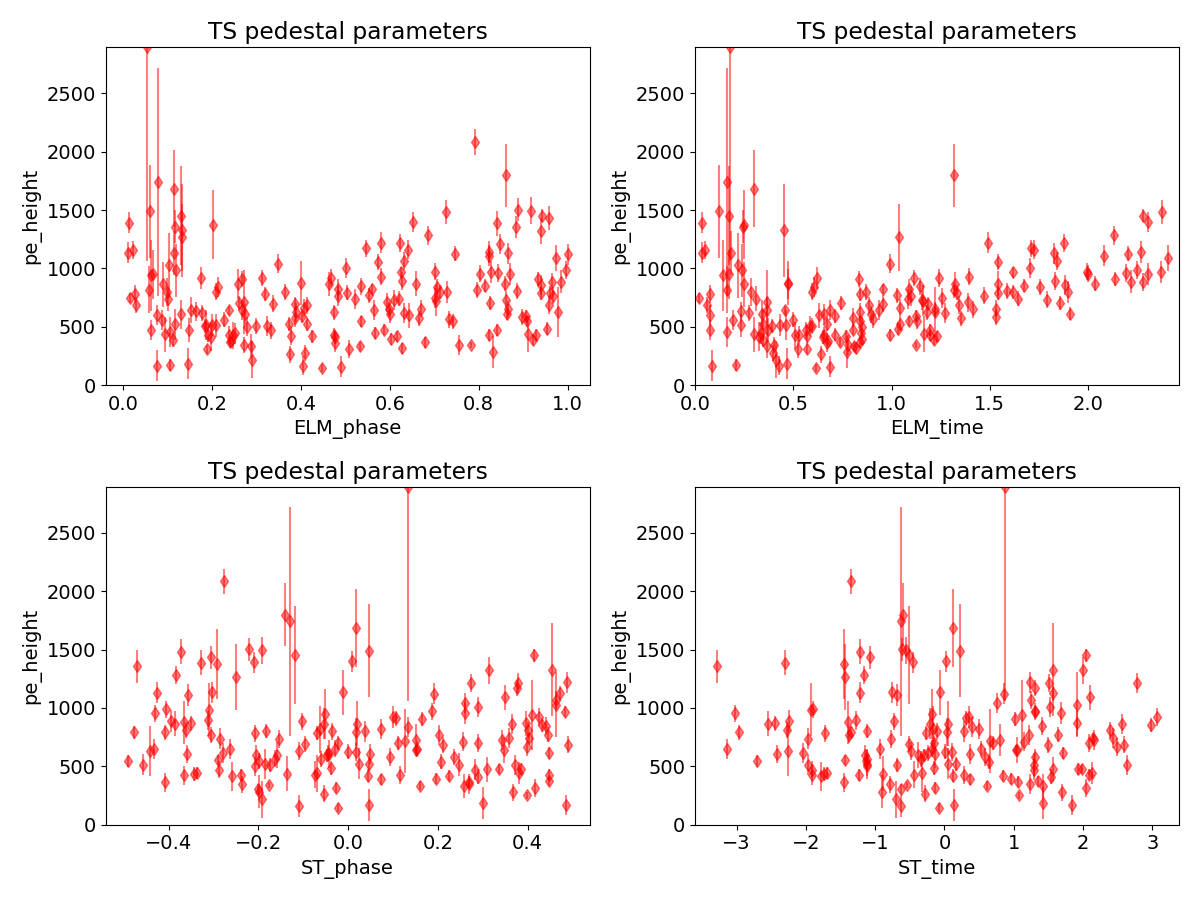

In [31]:
# Create a single figure with multiple subplots
variable = 'pe' # One of 'pe', 'Te', 'ne'
parameter = 'height' # One of 'grad', 'height', 'width'
fig, axes = plt.subplots(2, 2, figsize=(12, 9))  # 2 rows, 2 columns

# Plot on each subplot
scatter_pedestal_params_4plots(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals', x='ELM_phase', s=variable, p=parameter, ax=axes[0, 0])
scatter_pedestal_params_4plots(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals', x='ELM_time', s=variable, p=parameter, ax=axes[0, 1])
scatter_pedestal_params_4plots(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals', x='ST_phase', s=variable, p=parameter, ax=axes[1, 0])
scatter_pedestal_params_4plots(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals', x='ST_time', s=variable, p=parameter, ax=axes[1, 1])

plt.tight_layout()  # Adjust layout for better appearance
plt.show()

Text(0, 0.5, 'Pedestal pressure height [Pa]')

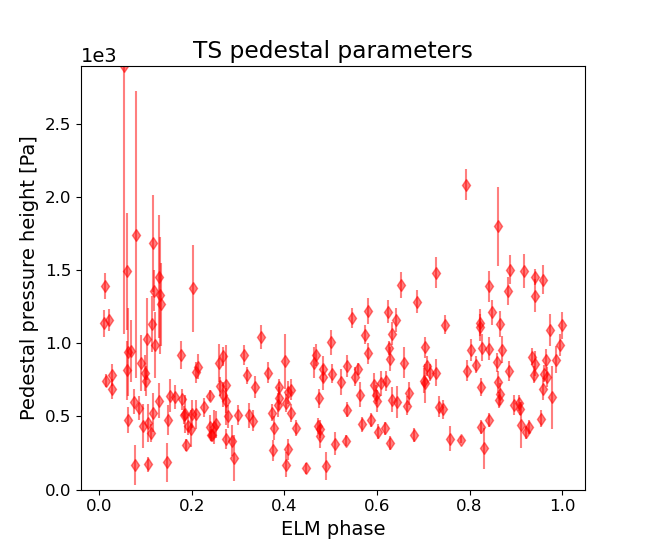

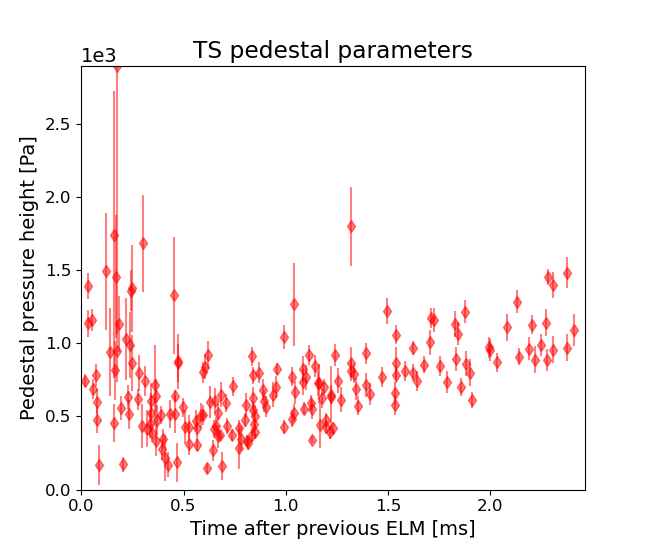

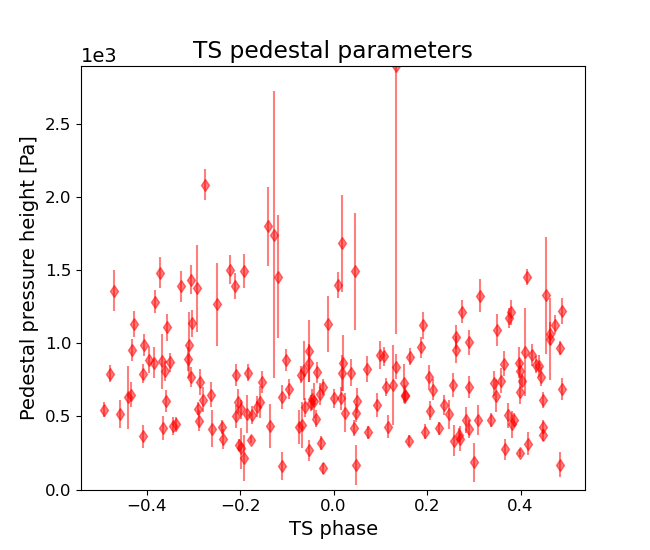

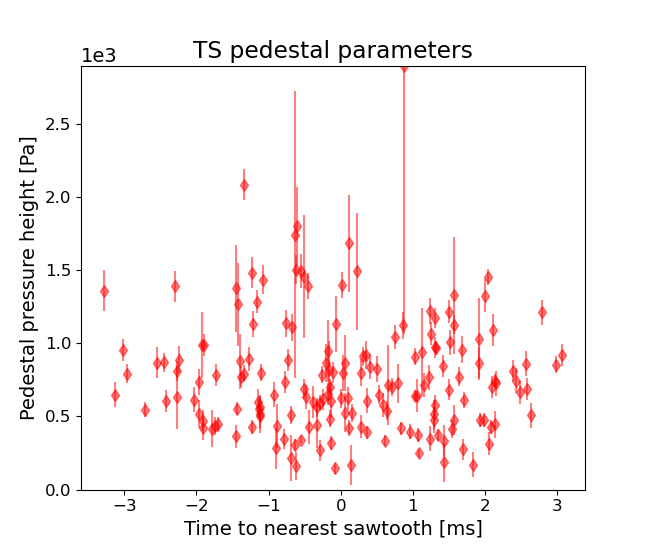

In [19]:
#Plots each figure seperately

variable = 'pe' # One of 'pe', 'Te', 'ne'
parameter = 'height' # One of 'grad', 'height', 'width'

# Generate plots
scatter_pedestal_params(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals', x='ELM_phase', s=variable, p=parameter)
plt.xlabel('ELM phase')
plt.ylabel('Pedestal pressure height [Pa]')


scatter_pedestal_params(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals',x='ELM_time', s=variable, p=parameter)
plt.xlabel('Time after previous ELM [ms]')
plt.ylabel('Pedestal pressure height [Pa]')


scatter_pedestal_params(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals',x='ST_phase', s=variable, p=parameter)
plt.xlabel('TS phase')
plt.ylabel('Pedestal pressure height [Pa]')

scatter_pedestal_params(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals',x='ST_time', s=variable, p=parameter)
plt.xlabel('Time to nearest sawtooth [ms]')
plt.ylabel('Pedestal pressure height [Pa]')

# <ins>  ST detection

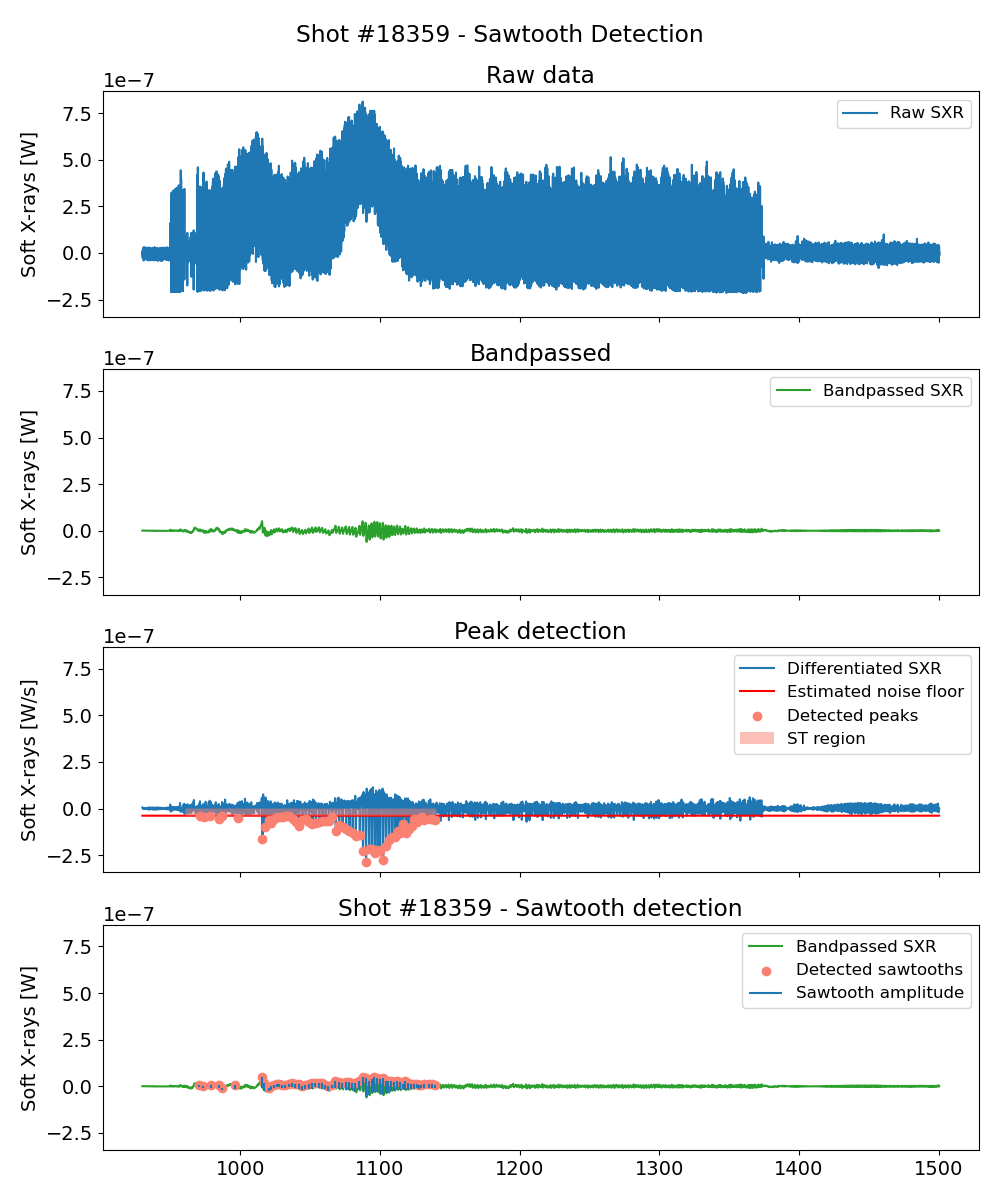

In [5]:
ST_detector_plot(shot_nr=18359, save_path='savesaw', is_core=True,share_y=True)

In [4]:
ST_detector(18359, with_plots=False,save_path=savesaw, is_core=True)

SawtoothCrashes(shot_number=18359, times=array([ 970.932 ,  973.8805,  978.473 ,  985.098 ,  987.3335,  998.644 ,
       1015.9595, 1017.734 , 1020.714 , 1022.375 , 1024.472 , 1026.385 ,
       1028.232 , 1030.332 , 1032.692 , 1035.0845, 1037.5135, 1039.8495,
       1042.1675, 1044.5515, 1046.9165, 1049.2735, 1051.7735, 1054.1615,
       1056.673 , 1059.021 , 1061.147 , 1063.5205, 1065.968 , 1068.441 ,
       1070.9135, 1073.3185, 1075.8975, 1078.259 , 1080.575 , 1082.775 ,
       1085.629 , 1087.894 , 1090.136 , 1092.34  , 1094.3125, 1096.3585,
       1098.37  , 1100.203 , 1102.337 , 1104.418 , 1106.4685, 1108.535 ,
       1110.5905, 1112.663 , 1114.704 , 1116.518 , 1118.5265, 1120.5515,
       1122.6695, 1124.615 , 1126.622 , 1128.458 , 1130.164 , 1131.9495,
       1135.553 , 1137.546 , 1139.6885]), amplitudes=array([9.05105823e-09, 1.26002723e-08, 1.89905429e-08, 1.58779681e-08,
       9.79023075e-09, 1.74307113e-08, 6.17856494e-08, 4.15267049e-08,
       1.70259121e-08, 2.28796808e